In [1]:
import tensorflow as tf

print(len(tf.config.list_physical_devices('GPU')) > 0)

True


In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fast_ml.feature_selection import get_constant_features
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_extraction.text import HashingVectorizer
import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import xgboost

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt

import pickle

%matplotlib inline

In [6]:
X_resampled = pd.read_csv('csv_balanced/X_resampled.csv')
y_resampled = pd.read_csv('csv_balanced/y_resampled.csv')

Xtrain, Xtest, ytrain, ytest = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(8895369, 14) (3812301, 14) (8895369, 1) (3812301, 1)


In [7]:
transformer = PowerTransformer(method = 'yeo-johnson', standardize=True)

Xtrain_transformed = transformer.fit_transform(Xtrain)

Xtest_transformed = transformer.transform(Xtest)

In [8]:
Xtrain_transformed = pd.DataFrame(Xtrain_transformed, columns=Xtrain.columns)
Xtest_transformed = pd.DataFrame(Xtest_transformed, columns=Xtest.columns)

In [24]:
def build_model(hyperparameter):
    model = Sequential()
    counter = 0
    
    for i in range(hyperparameter.Int('num_layers',min_value = 1, max_value = 10)):
        if i == 0:
            model.add(Dense(
                hyperparameter.Int('units' + str(i), min_value = 8, max_value = 256, step = 8),
                hyperparameter.Choice('activation' + str(i), values = ['relu', 'selu', 'tanh', 'sigmoid']),
                kernel_initializer = 'he_uniform', kernel_regularizer = 'l2',
                input_dim = Xtrain_transformed.shape[1]
            ))
            counter += 1
        else:
            model.add(Dense(
                hyperparameter.Int('units' + str(i), min_value = 8, max_value = 256, step = 8),
                hyperparameter.Choice('activation' + str(i), values = ['relu', 'selu', 'tanh', 'sigmoid']),
                kernel_initializer = 'he_uniform', kernel_regularizer = 'l2'
            ))
            model.add(Dropout(hyperparameter.Choice('dropout' + str(i), values=[0.1,0.2,0.3,0.4,0.5,0.6])))
            model.add(BatchNormalization())
            
    model.add(Dense(1, activation='sigmoid'))
    model.compile(hyperparameter.Choice(
        'optimizer', values = ['adam', 'rmsprop', 'sgd', 'adadelta', 'adagrad']), 
                  loss='binary_crossentropy', metrics=['accuracy']
                  )
    return model

In [25]:
tuner = kt.Hyperband(hypermodel = build_model, max_epochs = 1, objective = ['val_accuracy'], 
                     directory = 'DNN_Hyperband_Tuner', project_name = 'trial_02')

In [26]:
tuner.search(Xtrain_transformed[:1000000], ytrain[:1000000], epochs = 3, 
             validation_data = (Xtest_transformed[:1000000], ytest[:1000000]), validation_split=0.3)

Trial 1 Complete [00h 07m 14s]
multi_objective: -0.9938259720802307

Best multi_objective So Far: -0.9938259720802307
Total elapsed time: 00h 07m 14s


In [27]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 4,
 'units0': 48,
 'activation0': 'relu',
 'optimizer': 'rmsprop',
 'tuner/epochs': 1,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0,
 'units1': 8,
 'activation1': 'relu',
 'dropout1': 0.1,
 'units2': 8,
 'activation2': 'relu',
 'dropout2': 0.1,
 'units3': 8,
 'activation3': 'relu',
 'dropout3': 0.1}

In [28]:
tuned_model = tuner.get_best_models()[0]
tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 48)                720       
                                                                 
 dense_1 (Dense)             (None, 8)                 392       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                        

In [29]:
early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.003,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,)

tuned_dl_model_checkpoint = ModelCheckpoint('tuned_dnn.h5', monitor='val_accuracy', mode='auto', 
                                            verbose=1, save_best_only=True)

In [30]:
tuned_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
tuned_history = tuned_model.fit(Xtrain_transformed[:1000000], ytrain[:1000000], batch_size=32, epochs=50, 
                    validation_data=(Xtest_transformed[:1000000], ytest[:1000000]),
                    validation_split=0.2,
                    callbacks=[early_stopping, tuned_dl_model_checkpoint])

Epoch 1/50
31250/31250 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.9911
Epoch 1: val_accuracy improved from -inf to 0.99334, saving model to tuned_dnn.h5
31250/31250 [==============================] - 442s 14ms/step - loss: 0.0512 - accuracy: 0.9911 - val_loss: 0.0346 - val_accuracy: 0.9933
Epoch 2/50
31248/31250 [============================>.] - ETA: 0s - loss: 0.0487 - accuracy: 0.9916
Epoch 2: val_accuracy improved from 0.99334 to 0.99422, saving model to tuned_dnn.h5
31250/31250 [==============================] - 451s 14ms/step - loss: 0.0487 - accuracy: 0.9916 - val_loss: 0.0345 - val_accuracy: 0.9942
Epoch 3/50
31246/31250 [============================>.] - ETA: 0s - loss: 0.0485 - accuracy: 0.9918
Epoch 3: val_accuracy did not improve from 0.99422
31250/31250 [==============================] - 426s 14ms/step - loss: 0.0485 - accuracy: 0.9918 - val_loss: 0.0374 - val_accuracy: 0.9935
Epoch 4/50
31249/31250 [============================>.] - ETA: 0s - 

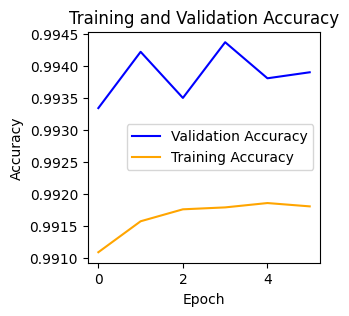

In [35]:
plt.figure(figsize=(3,3))

plt.plot(tuned_history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.plot(tuned_history.history['accuracy'], color='orange', label='Training Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.legend()

plt.show()

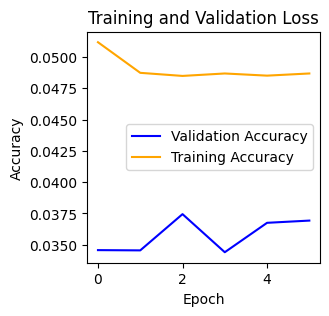

In [36]:
plt.figure(figsize=(3,3))

plt.plot(tuned_history.history['val_loss'], color='blue', label='Validation Accuracy')
plt.plot(tuned_history.history['loss'], color='orange', label='Training Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')

plt.legend()

plt.show()

In [37]:
## Checking the metrics for this model

y_pred = tuned_model.predict(Xtest_transformed[1000000:1500000])

y_pred = (y_pred > 0.5).astype(int) # converting the probabilities to 0 and 1

accuracy = accuracy_score(ytest[1000000:1500000], y_pred)

print("Accuracy = {}".format(accuracy))


15625/15625 [==============================] - 35s 2ms/step
Accuracy = 0.993434


In [38]:
print(classification_report(ytest[1000000:1500000], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    250228
           1       0.99      1.00      0.99    249772

    accuracy                           0.99    500000
   macro avg       0.99      0.99      0.99    500000
weighted avg       0.99      0.99      0.99    500000



In [39]:
confusion_matrix(ytest[1000000:1500000], y_pred)

array([[247713,   2515],
       [   768, 249004]], dtype=int64)

### Contrast with Untuned DNN Model - - 

- The tuned DNN exhibits a False Negative (FN) count of 768, compared to the DNN model's count of 922.
- This reduction is notably substantial, providing increased reliability for the current business model.